In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/MyDrive/DeepL/Image Search Engine")

In [3]:
!dir

cat.jpeg  dataset	index.csv   Project-1\ Image\ Search\ engine.ipynb
DATA	  index_23.csv	index.xlsx  test_images


In [4]:
# import the necessary packages
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm
import imutils
import warnings
import glob
import csv



warnings.filterwarnings("ignore")

### Step 1: Defining our Image Descriptor

In [5]:
class ColorDescriptor:
    
    def __init__(self, bins):
        # store the number of bins for the 3D histogram
        self.bins = bins

    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))

        # divide the image into four rectangles/segments (top-left,
        # top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
            (0, cX, cY, h)]

        # construct an elliptical mask representing the center of the
        # image
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)

            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)

        # return the feature vector
        return features

    def histogram(self, image, mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
            [0, 180, 0, 256, 0, 256])


        hist = cv2.normalize(hist, hist).flatten()

        # return the histogram
        return hist

### Step 2: Extracting Features from Our Dataset

In [6]:
FILE_NAME = "index_23.csv"
DATA = "dataset"

In [7]:
# initialize the color descriptor
cd = ColorDescriptor((8, 12, 3))

# open the output index file for writing
output = open(FILE_NAME, "w")

In [8]:
# progress bar 
with tqdm(total=len(glob.glob(DATA + "/*.png"))) as pbar:
    
    # use glob to grab the image paths and loop over them
    for imagePath in glob.glob(DATA + "/*.png"):
        # extract the image ID (i.e. the unique filename) from the image
        # path and load the image itself
        imageID = imagePath[imagePath.rfind("\\") + 1:]

        image = cv2.imread(imagePath)

        # describe the image
        features = cd.describe(image)


        # write the features to file
        features = [str(f) for f in features]
        
        output.write("%s,%s\n" % (imageID, ",".join(features)))
        
        # update the progressbar
        pbar.update(1)

# close the index file
output.close()

  0%|          | 0/805 [00:00<?, ?it/s]

###  Step 3: The Searcher

In [9]:
class Searcher:
    
    def __init__(self, indexPath):
        
        # store our index path
        self.indexPath = indexPath

    def search(self, queryFeatures, limit = 10):
        # initialize our dictionary of results
        results = {}

        # open the index file for reading
        with open(self.indexPath) as f:
            
            # initialize the CSV reader
            reader = csv.reader(f)

            # loop over the rows in the index
            for row in reader: # 1000
                # parse out the image ID and features, then compute the
                # chi-squared distance between the features in our index
                # and our query features
                features = [float(x) for x in row[1:]] 
                d = self.chi2_distance(features, queryFeatures) # 1000

                # now that we have the distance between the two feature
                # vectors, we can udpate the results dictionary -- the
                # key is the current image ID in the index and the
                # value is the distance we just computed, representing
                # how 'similar' the image in the index is to our query
                results[row[0]] = d

            # close the reader
            f.close()

        # sort our results, so that the smaller distances (i.e. the
        # more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])

        # return our (limited) results
        return results[:limit]

    def chi2_distance(self, histA, histB, eps = 1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])

        # return the chi-squared distance
        return d

### Step 4: Performing a Search

In [10]:
TEST_IMG = "test_images/108100.png"
INDEX_FILE = "index.csv"

In [11]:
# initialize the image descriptor
cd = ColorDescriptor((8, 12, 3))

In [12]:
# load the query image and describe it
img = cv2.imread(TEST_IMG)
features = cd.describe(img)

In [13]:
features

[0.0,
 0.0,
 0.61585873,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4084534,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09986183,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01496603,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2209145,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [14]:
len(features)

1440

In [15]:
# perform the search
searcher = Searcher(INDEX_FILE)

In [16]:
%%time

results = searcher.search(features)

CPU times: user 5.11 s, sys: 24.9 ms, total: 5.13 s
Wall time: 5.57 s


In [17]:
import matplotlib.pyplot as plt
import os

0.6648564356870521
2.12092730561945
3.2821114361694743
3.786903411355495
3.817981174446911
4.658789208188686
4.845210884289385
5.002623672661139
5.103561598565077
5.551684444610595


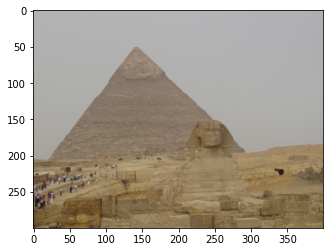

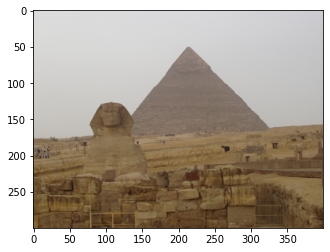

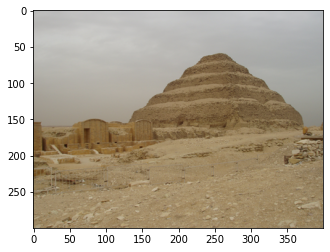

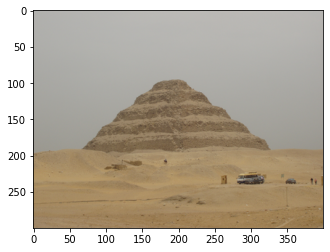

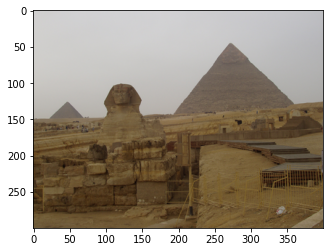

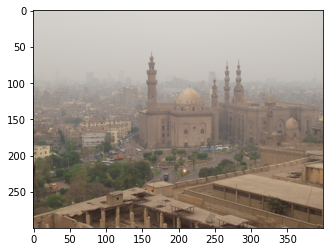

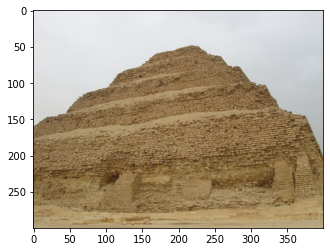

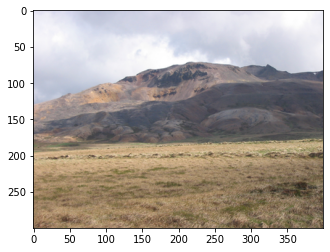

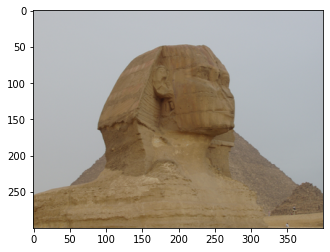

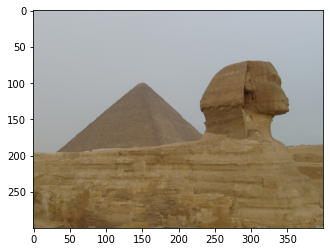

In [18]:
# display the query
# cv2.imshow("Query", img)

# loop over the results
for (score, resultID) in results:
    plt.subplots()
    # load the result image and display it
    result = cv2.imread(DATA + "/" + resultID)
    img= cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    print(score)
    plt.imshow(img)
    
    
    # cv2.imshow("Result", result)
    

In [19]:
a = []
for (score, resultID) in results:
    a.append(resultID)

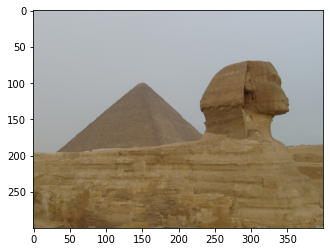

In [20]:
result = cv2.imread(DATA + "/" + a[9])
img= cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# print(score)
plt.imshow(img)

In [21]:
cv2.destroyAllWindows()